In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

Data generation

In [308]:
#Define the number of elements in each set I, J, K
i_num = 25
k_num = 5
j_num = 500 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])


In [309]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 5000), 0)
    I.loc[i, 'Longitude'] = round(random.uniform(0, 5000), 0)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 5000), 0)
    K.loc[k, 'Longitude'] = round(random.uniform(0, 5000), 0)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 5000), 0)
    J.loc[j, 'Longitude'] = round(random.uniform(0, 5000), 0)

J.index = J['Point number'] 
J = pd.concat([J, K, I], axis = 0) #Include K to J
J

,Point number,Latitude,Longitude
Point number,,,
j0,j0,1053.0,1172.0
j1,j1,4472.0,879.0
j2,j2,2419.0,566.0
j3,j3,3918.0,1827.0
j4,j4,3447.0,3011.0
...,...,...,...
i20,i20,4254.0,1414.0
i21,i21,4289.0,1417.0
i22,i22,1344.0,2427.0


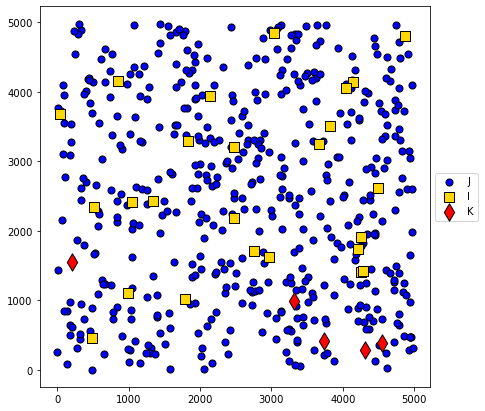

In [310]:
axs, fig = plt.subplots(1, 1, figsize = (7, 7))

fig.scatter(J['Latitude'], J['Longitude'], color = 'blue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Latitude'], K['Longitude'], color = 'red', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [311]:
# from pathlib import Path
# import pandas as pd
# import geopandas as gpd
# import shapely
# #%pip install folium matplotlib mapclassify
# import folium
# import matplotlib

# # Doctor's coordinates
# doctors = {'Latitude' : [48.56500199216254, 48.5705, 48.575], 'Longitude' : [13.433214775837387, 13.436, 13.44]}
# df = pd.DataFrame(doctors)
# df

# # create geodataframe, NB CRS
# geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Latitude"], df["Longitude"]), crs="epsg:4386")


# with open('Polygon Passau.txt', 'r') as file:
#     # Read the contents of the file into a string
#     polygon_str = file.read()

# # Now file_contents contains the contents of the file as a string
# passau_poly = shapely.wkt.loads(polygon_str)


# passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
# passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)
# folium.GeoJson(passau_gdf).add_to(passau_map)

# geo_doctors = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Latitude"], df["Longitude"]), crs="epsg:4326")

# for idx, row in geo_doctors.iterrows():
#     folium.Marker([row['Latitude'], row['Longitude']], icon=folium.Icon(icon='circle', prefix='fa', color='blue'), 
#                   icon_size=(0.5, 0.5)).add_to(passau_map)

# lines = []
# for i in range(len(geo_doctors) - 1):
#     point1 = geo_doctors.iloc[i].geometry
#     point2 = geo_doctors.iloc[i + 1].geometry
#     lines.append([point1.coords[0], point2.coords[0]])

# folium.PolyLine(lines, color='blue').add_to(passau_map)



# passau_map

In [312]:
#Define constants

B = 90 * 60 #battery load: seconds of travel
S = 17 * (10 * 60) #meters of service time
alpha = 14760 + 500 #euro

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 400000
    else:
        beta[j] = 300000
        
gamma = 1000 #0.0045 / 1000 # variable cost in euro per m
        
q_j = {j: 50 for j in J.index}

up_bound = 12
mu = {i : int(round(random.uniform(0, up_bound), 0)) for i in I.index}

mu

{'i0': 1,
 'i1': 11,
 'i2': 4,
 'i3': 5,
 'i4': 9,
 'i5': 11,
 'i6': 5,
 'i7': 9,
 'i8': 9,
 'i9': 8,
 'i10': 4,
 'i11': 5,
 'i12': 9,
 'i13': 4,
 'i14': 3,
 'i15': 6,
 'i16': 7,
 'i17': 4,
 'i18': 6,
 'i19': 10,
 'i20': 9,
 'i21': 4,
 'i22': 2,
 'i23': 2,
 'i24': 7}

Deterministic model

In [313]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 0,
 'i1': 15,
 'i2': 2,
 'i3': 7,
 'i4': 13,
 'i5': 8,
 'i6': 4,
 'i7': 13,
 'i8': 10,
 'i9': 10,
 'i10': 4,
 'i11': 5,
 'i12': 9,
 'i13': 3,
 'i14': 4,
 'i15': 4,
 'i16': 7,
 'i17': 6,
 'i18': 6,
 'i19': 9,
 'i20': 6,
 'i21': 5,
 'i22': 2,
 'i23': 1,
 'i24': 6}

In [314]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 930.4799836643451,
 ('k0', 'j1'): 4320.215851088925,
 ('k0', 'j2'): 2424.8540162244817,
 ('k0', 'j3'): 3722.9495027464445,
 ('k0', 'j4'): 3553.941473913154,
 ('k0', 'j5'): 3264.088540465776,
 ('k0', 'j6'): 2036.4392944549072,
 ('k0', 'j7'): 1296.8504154296286,
 ('k0', 'j8'): 4491.219990158576,
 ('k0', 'j9'): 4379.5754360440005,
 ('k0', 'j10'): 2189.6942708971956,
 ('k0', 'j11'): 3015.7831487028375,
 ('k0', 'j12'): 905.2436136201128,
 ('k0', 'j13'): 4719.943431864412,
 ('k0', 'j14'): 4529.553841163608,
 ('k0', 'j15'): 3341.6877472319284,
 ('k0', 'j16'): 4592.873719143604,
 ('k0', 'j17'): 854.9163701789784,
 ('k0', 'j18'): 3217.315651284468,
 ('k0', 'j19'): 3959.061126075221,
 ('k0', 'j20'): 2245.9781833312627,
 ('k0', 'j21'): 3610.8558542262526,
 ('k0', 'j22'): 2300.6403456429257,
 ('k0', 'j23'): 1551.5943413147652,
 ('k0', 'j24'): 2887.8732659173256,
 ('k0', 'j25'): 4508.037821491741,
 ('k0', 'j26'): 5403.002313529026,
 ('k0', 'j27'): 1449.2515309634832,
 ('k0', 'j28'): 

In [315]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j2'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j10'),
 ('k0', 'j12'),
 ('k0', 'j17'),
 ('k0', 'j20'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j27'),
 ('k0', 'j29'),
 ('k0', 'j32'),
 ('k0', 'j34'),
 ('k0', 'j37'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j42'),
 ('k0', 'j45'),
 ('k0', 'j47'),
 ('k0', 'j49'),
 ('k0', 'j51'),
 ('k0', 'j53'),
 ('k0', 'j59'),
 ('k0', 'j61'),
 ('k0', 'j63'),
 ('k0', 'j68'),
 ('k0', 'j70'),
 ('k0', 'j71'),
 ('k0', 'j72'),
 ('k0', 'j73'),
 ('k0', 'j74'),
 ('k0', 'j75'),
 ('k0', 'j76'),
 ('k0', 'j78'),
 ('k0', 'j82'),
 ('k0', 'j83'),
 ('k0', 'j92'),
 ('k0', 'j93'),
 ('k0', 'j94'),
 ('k0', 'j96'),
 ('k0', 'j97'),
 ('k0', 'j98'),
 ('k0', 'j100'),
 ('k0', 'j103'),
 ('k0', 'j104'),
 ('k0', 'j109'),
 ('k0', 'j115'),
 ('k0', 'j116'),
 ('k0', 'j117'),
 ('k0', 'j120'),
 ('k0', 'j121'),
 ('k0', 'j122'),
 ('k0', 'j128'),
 ('k0', 'j130'),
 ('k0', 'j134'),
 ('k0', 'j135'),
 ('k0', 'j138'),
 ('k0', 'j139'),
 ('k0', 'j148'),
 ('k0', 'j149'),
 ('k0', 'j

In [316]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas


[('k0', 'j0'),
 ('k0', 'j2'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j10'),
 ('k0', 'j12'),
 ('k0', 'j17'),
 ('k0', 'j20'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j27'),
 ('k0', 'j29'),
 ('k0', 'j32'),
 ('k0', 'j34'),
 ('k0', 'j37'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j42'),
 ('k0', 'j45'),
 ('k0', 'j47'),
 ('k0', 'j49'),
 ('k0', 'j51'),
 ('k0', 'j53'),
 ('k0', 'j59'),
 ('k0', 'j61'),
 ('k0', 'j63'),
 ('k0', 'j68'),
 ('k0', 'j70'),
 ('k0', 'j71'),
 ('k0', 'j72'),
 ('k0', 'j73'),
 ('k0', 'j74'),
 ('k0', 'j75'),
 ('k0', 'j76'),
 ('k0', 'j78'),
 ('k0', 'j82'),
 ('k0', 'j83'),
 ('k0', 'j92'),
 ('k0', 'j93'),
 ('k0', 'j94'),
 ('k0', 'j96'),
 ('k0', 'j97'),
 ('k0', 'j98'),
 ('k0', 'j100'),
 ('k0', 'j103'),
 ('k0', 'j104'),
 ('k0', 'j109'),
 ('k0', 'j115'),
 ('k0', 'j116'),
 ('k0', 'j117'),
 ('k0', 'j120'),
 ('k0', 'j121'),
 ('k0', 'j122'),
 ('k0', 'j128'),
 ('k0', 'j130'),
 ('k0', 'j134'),
 ('k0', 'j135'),
 ('k0', 'j138'),
 ('k0', 'j139'),
 ('k0', 'j148'),
 ('k0', 'j149'),
 ('k0', 'j

In [317]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [318]:
model_det = gp.Model('Deterministic model without relaxation')

x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [319]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c6')

{('k0', 'j7', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i6'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i18'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i19'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i22'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j17', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j17', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j17', 'i6'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j17', 'i8'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j17', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j17', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j17', 'i18'): <gurobi.Constr *Awaiting Model Up

In [320]:
model_det.setObjective(alpha * gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i] for i in I.index) + gp.quicksum(beta[j] * y_j[j] for j in J.index) + gamma * gp.quicksum((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] for (k, j) in N_i[i] for i in I.index), GRB.MINIMIZE)
model_det.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2247 rows, 28805 columns and 17123 nonzeros
Model fingerprint: 0x0514db86
Variable types: 0 continuous, 28805 integer (530 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [2e+04, 2e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 1.864101e+08
Presolve removed 1175 rows and 21803 columns
Presolve time: 0.05s
Presolved: 1072 rows, 7002 columns, 14321 nonzeros
Found heuristic solution: objective 1.805101e+08
Variable types: 0 continuous, 7002 integer (381 binary)

Root relaxation: objective 1.862427e+07, 1441 iterations, 0.05 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj

In [321]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, v.X))
                                #print(v)
                print("\n")
                
        print("\n")
        
ListSolution(model_det)

Number of solutions found: 6
0
1.52896e+08 
x_ikj[i1,k1,k3] 15
x_ikj[i2,k0,k0] 2
x_ikj[i3,k3,k3] 7
x_ikj[i4,k1,k3] 13
x_ikj[i5,k3,k3] 8
x_ikj[i6,k3,k3] 4
x_ikj[i8,k0,k0] 10
x_ikj[i9,k0,k0] 10
x_ikj[i11,k1,k3] 5
x_ikj[i15,k4,k3] 4
x_ikj[i16,k3,k3] 7
x_ikj[i17,k3,k3] 6
x_ikj[i18,k4,k3] 6
x_ikj[i19,k0,k0] 9
x_ikj[i20,k1,k3] 6
x_ikj[i21,k1,k3] 11
x_ikj[i21,k2,k3] 50
x_ikj[i21,k4,k3] 39
x_ikj[i22,k3,k3] 18
x_ikj[i23,k4,k3] 1
x_ikj[i24,k0,k0] 6
y_j[k0] 1
y_j[k3] 1


1
1.5296e+08 
x_ikj[i1,k1,k3] 15
x_ikj[i2,k0,k0] 2
x_ikj[i3,k3,k3] 7
x_ikj[i4,k1,k3] 13
x_ikj[i5,k3,k3] 8
x_ikj[i6,k3,k3] 4
x_ikj[i8,k0,k0] 10
x_ikj[i9,k0,k0] 10
x_ikj[i11,k1,k3] 5
x_ikj[i15,k4,k3] 4
x_ikj[i16,k3,k3] 7
x_ikj[i17,k3,k3] 6
x_ikj[i18,k4,k3] 6
x_ikj[i19,k0,k0] 9
x_ikj[i20,k1,k3] 6
x_ikj[i21,k1,k3] 11
x_ikj[i21,k2,k3] 50
x_ikj[i21,k4,k3] 39
x_ikj[i22,k3,k3] 18
x_ikj[i23,k4,k3] 1
x_ikj[i24,k0,k0] 6
y_j[k0] 1
y_j[k3] 1


2
1.53122e+08 
x_ikj[i1,k1,k3] 15
x_ikj[i2,k0,k0] 2
x_ikj[i3,k3,k3] 7
x_ikj[i4,k1,k3] 13
x_ikj[i5,k3

In [322]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    return results_doctors, results_locations

SolutionSummary(model_det)

(      i  Number of drones
 0    i1                15
 1   i11                 5
 2   i15                 4
 3   i16                 7
 4   i17                 6
 5   i18                 6
 6   i19                 9
 7    i2                 2
 8   i20                 6
 9   i21               100
 10  i22                18
 11  i23                 1
 12  i24                 6
 13   i3                 7
 14   i4                13
 15   i5                 8
 16   i6                 4
 17   i8                10
 18   i9                10,
     j  Number of drones
 0  k0                37
 1  k3               200)

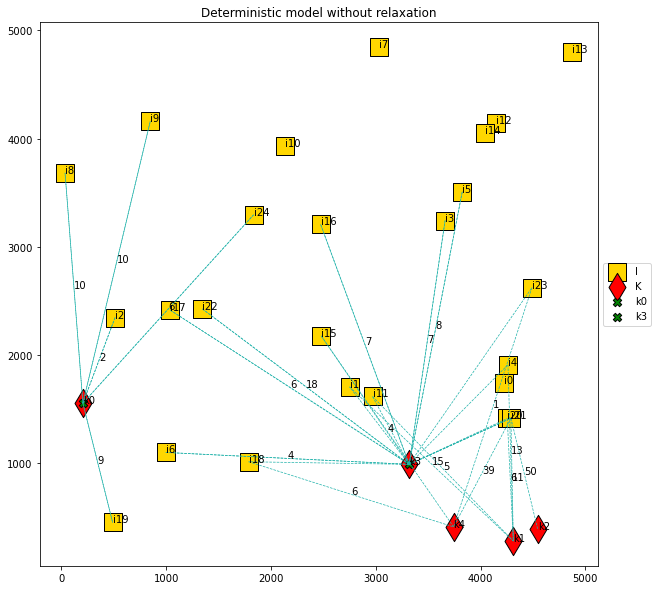

In [323]:
def SolutionGraph(I, K, J, model):
        
        axs, fig = plt.subplots(1, 1, figsize = (10, 10))
                
        fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 300, label = 'I')
        for i in range (len(I.index)):
                fig.annotate(I.index[i], (I['Latitude'][i], I['Longitude'][i]))
                
        fig.scatter(K['Latitude'], K['Longitude'], color = 'red', edgecolors = 'black',
                                marker = 'd', s = 400, label = 'K')
        for k in range (len(K.index)):
                fig.annotate(K.index[k], (K['Latitude'][k], K['Longitude'][k]))
        
        fig.set_title(model.ModelName)
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        (J.loc[indices_x[2], 'Longitude'], I.loc[indices_x[0], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.plot((I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                        (I.loc[indices_x[0], 'Longitude'], K.loc[indices_x[1], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                                (K.loc[indices_x[1], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                                #fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                                #(J.loc[indices_x[2], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Latitude'], J.loc[index_y, 'Longitude'], color = 'green',
                                        edgecolors = 'black', s = 70, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

SolutionGraph(I, K, J, model_det)

In [324]:
for v in model_det.getVars():
        if v.xn > 0:
            if v.varName.startswith('x_ikj'):
                indices_x = v.varName[6:-1].split(',')
indices_x

['i24', 'k0', 'k0']

Probabilistic model

In [325]:
#Define constants and random variables

theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

p = 0.98

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = int(theta_ran_i[i].ppf(p))


g_i = {}
for i in theta_ran_i.keys():
    g_i[i] = mu[i] * 15

IG = []
for i in I.index:
    for g in range(1, g_i[i] + 1):
        IG.append((i, g))

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in IG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))

In [326]:
model_prob = gp.Model('Probabilistic model without relaxation')

x_ikj = model_prob.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [327]:
#Probabilistic constraints

model_prob.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i0', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 4): <gurobi.Constr *Awaiting Mod

In [328]:
#Same constraints as in the deterministic model

model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')
model_prob.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')
model_prob.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c19')

{('k0', 'j7', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i6'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i18'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i19'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i22'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j17', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j17', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j17', 'i6'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j17', 'i8'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j17', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j17', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j17', 'i18'): <gurobi.Constr *Awaiting Model Up

In [329]:
model_prob.setObjective(alpha * gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i] for i in I.index) + gp.quicksum(beta[j] * y_j[j] for j in J.index) + gamma * gp.quicksum((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] for (k, j) in N_i[i] for i in I.index), GRB.MINIMIZE)
model_prob.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4103 rows, 31115 columns and 5004853 nonzeros
Model fingerprint: 0x2569f51d
Variable types: 0 continuous, 31115 integer (2840 binary)
Coefficient statistics:
  Matrix range     [1e-13, 5e+03]
  Objective range  [2e+04, 2e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 9.664709e+08
Presolve removed 2984 rows and 23267 columns
Presolve time: 3.03s
Presolved: 1119 rows, 7848 columns, 16019 nonzeros
Variable types: 0 continuous, 7848 integer (397 binary)
Found heuristic solution: objective 9.664251e+08

Root relaxation: objective 4.024742e+07, 2743 iterations, 0.04 seconds 

In [330]:
ListSolution(model_prob)

Number of solutions found: 7
0
1.53229e+08 
x_ikj[i0,k2,k3] 3
x_ikj[i1,k2,k3] 18
x_ikj[i2,k0,i18] 9
x_ikj[i3,k3,k3] 10
x_ikj[i4,k1,k3] 16
x_ikj[i5,k3,k3] 18
x_ikj[i6,k3,i18] 10
x_ikj[i8,k0,j49] 16
x_ikj[i9,k0,j49] 14
x_ikj[i11,k1,k3] 10
x_ikj[i15,k4,k3] 12
x_ikj[i16,k3,k3] 13
x_ikj[i17,k3,k3] 9
x_ikj[i18,k1,k3] 12
x_ikj[i19,k0,i18] 17
x_ikj[i20,k4,k3] 16
x_ikj[i21,k4,k3] 9
x_ikj[i22,k0,i18] 5
x_ikj[i23,k4,k3] 5
x_ikj[i24,k0,k0] 13
y_j[j49] 1
y_j[k0] 1
y_j[k3] 1
y_j[i18] 1


1
1.53429e+08 
x_ikj[i0,k2,k3] 3
x_ikj[i1,k2,k3] 18
x_ikj[i2,k0,i18] 9
x_ikj[i3,k3,k3] 10
x_ikj[i4,k1,k3] 16
x_ikj[i5,k3,k3] 18
x_ikj[i6,k3,i18] 10
x_ikj[i8,k0,j49] 16
x_ikj[i9,k0,j49] 14
x_ikj[i11,k1,k3] 10
x_ikj[i15,k4,k3] 12
x_ikj[i16,k3,k3] 13
x_ikj[i17,k3,k3] 9
x_ikj[i18,k1,k3] 12
x_ikj[i19,k0,i18] 17
x_ikj[i20,k4,k3] 16
x_ikj[i21,k4,k3] 9
x_ikj[i22,k0,i18] 5
x_ikj[i23,k4,k3] 5
x_ikj[i24,k0,k0] 13
y_j[j49] 1
y_j[k0] 1
y_j[k3] 1
y_j[i18] 1


2
1.53689e+08 
x_ikj[i0,k2,k3] 3
x_ikj[i1,k2,k3] 18
x_ikj[i2,k0,i18] 9


In [331]:
SolutionSummary(model_prob)

(      i  Number of drones
 0    i0                 3
 1    i1                18
 2   i11                10
 3   i15                12
 4   i16                13
 5   i17                 9
 6   i18                12
 7   i19                17
 8    i2                 9
 9   i20                16
 10  i21                 9
 11  i22                 5
 12  i23                 5
 13  i24                13
 14   i3                10
 15   i4                16
 16   i5                18
 17   i6                10
 18   i8                16
 19   i9                14,
      j  Number of drones
 0  i18                41
 1  j49                30
 2   k0                13
 3   k3               151)

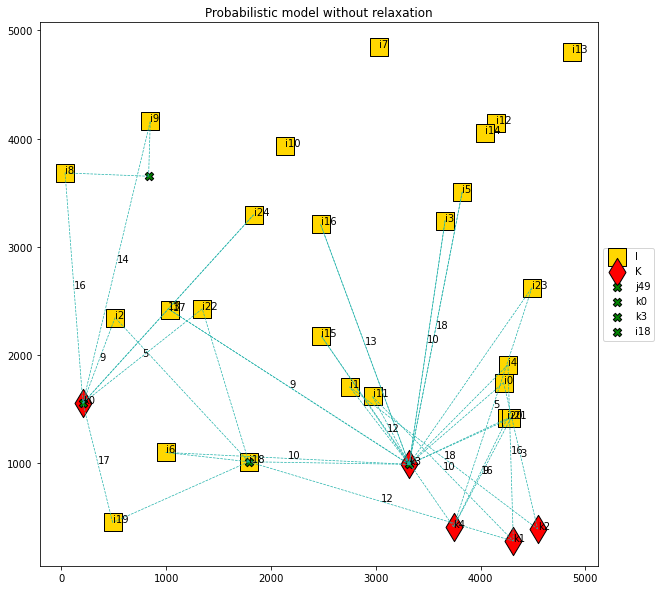

In [332]:
SolutionGraph(I, K, J, model_prob)

Probabilistic model with relaxed constraints

In [333]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 (

In [334]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 (

In [335]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [336]:
#Redefine constants and random variables


I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))

In [337]:
model_prob_rel = gp.Model('Probabilistic model with relaxation')

x_ikj = model_prob_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob_rel.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [338]:
model_prob_rel.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')



model_prob_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')


model_prob_rel.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c20')




Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('k0', 'j0', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i6'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i8'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i11'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i18'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i19'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i22'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j2', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j2', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j2', 'i6'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j2', 'i11'): <gurobi.Constr *Awaiting Model Update*>,

In [339]:
model_prob_rel.setObjective(alpha * gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i] for i in I.index) + gp.quicksum(beta[j] * y_j[j] for j in J.index) + gamma * gp.quicksum((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] for (k, j) in N_i[i] for i in I.index), GRB.MINIMIZE)
model_prob_rel.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 42444 rows, 67665 columns and 8421475 nonzeros
Model fingerprint: 0xad09382c
Variable types: 0 continuous, 67665 integer (2840 binary)
Coefficient statistics:
  Matrix range     [1e-13, 5e+03]
  Objective range  [2e+04, 1e+09]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1.366883e+10
Presolve removed 39826 rows and 33742 columns
Presolve time: 4.53s
Presolved: 2618 rows, 33923 columns, 69402 nonzeros
Variable types: 0 continuous, 33923 integer (530 binary)
Found heuristic solution: objective 1.366863e+10

Root simplex log...

Iteration    Objective       Primal Inf.    Du

In [340]:
ListSolution(model_prob_rel)

Number of solutions found: 4
0
4.65058e+08 
x_ikj[i0,k3,i19] 3
x_ikj[i1,k4,i13] 4
x_ikj[i1,k4,i19] 14
x_ikj[i2,k3,i19] 9
x_ikj[i3,k4,i13] 10
x_ikj[i4,k3,i19] 16
x_ikj[i5,k2,i13] 18
x_ikj[i6,k4,i19] 10
x_ikj[i7,k1,j183] 16
x_ikj[i8,k0,i19] 16
x_ikj[i9,k0,j183] 14
x_ikj[i10,k4,j183] 9
x_ikj[i11,k3,i19] 10
x_ikj[i12,k3,i13] 16
x_ikj[i13,k1,i13] 9
x_ikj[i14,k4,i13] 7
x_ikj[i15,k2,i19] 12
x_ikj[i16,k3,i13] 13
x_ikj[i17,k4,i19] 9
x_ikj[i18,k1,i19] 12
x_ikj[i19,k4,i19] 17
x_ikj[i20,k1,i19] 16
x_ikj[i21,k1,i19] 9
x_ikj[i22,k0,i19] 5
x_ikj[i23,k4,i13] 5
x_ikj[i24,k3,j183] 13
y_j[j183] 1
y_j[i13] 1
y_j[i19] 1


1
4.65658e+08 
x_ikj[i0,k3,i19] 3
x_ikj[i1,k4,i13] 4
x_ikj[i1,k4,i19] 14
x_ikj[i2,k3,i19] 9
x_ikj[i3,k4,i13] 10
x_ikj[i4,k3,i19] 16
x_ikj[i5,k2,i13] 18
x_ikj[i6,k4,i19] 10
x_ikj[i7,k1,j183] 16
x_ikj[i8,k0,i19] 16
x_ikj[i9,k0,j183] 14
x_ikj[i10,k4,j183] 9
x_ikj[i11,k3,i19] 10
x_ikj[i12,k3,i13] 16
x_ikj[i13,k1,i13] 9
x_ikj[i14,k4,i13] 7
x_ikj[i15,k2,i19] 12
x_ikj[i16,k3,i13] 13
x_ikj[i17,k4

In [341]:
SolutionSummary(model_prob_rel)

(      i  Number of drones
 0    i0                 3
 1    i1                18
 2   i10                 9
 3   i11                10
 4   i12                16
 5   i13                 9
 6   i14                 7
 7   i15                12
 8   i16                13
 9   i17                 9
 10  i18                12
 11  i19                17
 12   i2                 9
 13  i20                16
 14  i21                 9
 15  i22                 5
 16  i23                 5
 17  i24                13
 18   i3                10
 19   i4                16
 20   i5                18
 21   i6                10
 22   i7                16
 23   i8                16
 24   i9                14,
       j  Number of drones
 0   i13                82
 1   i19               158
 2  j183                52)

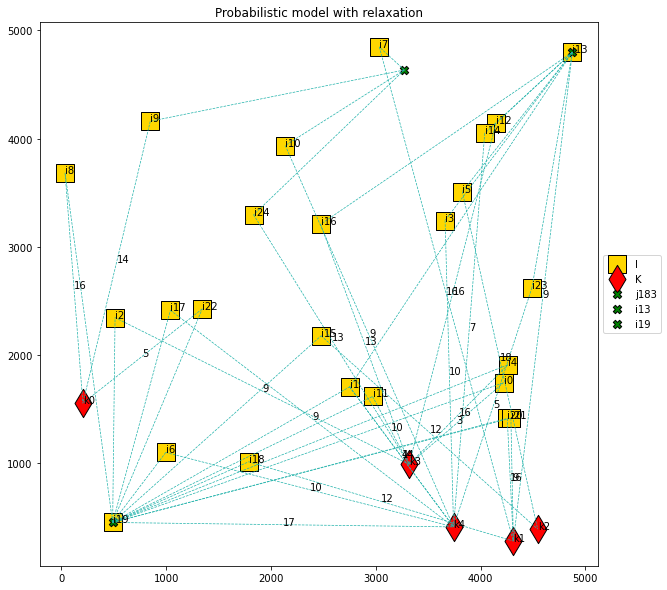

In [342]:
SolutionGraph(I, K, J, model_prob_rel)

Deterministic model with relaxed constraints

In [343]:
model_det_rel = gp.Model('Deterministic model with relaxation')

x_ikj = model_det_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [344]:
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c21')
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c22')

model_det_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')

model_det_rel.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c25')

model_det_rel.setObjective(alpha * gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i] for i in I.index) + gp.quicksum(beta[j] * y_j[j] for j in J.index) + gamma * gp.quicksum((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] for (k, j) in N_i[i] for i in I.index), GRB.MINIMIZE)
model_det_rel.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 40158 rows, 65355 columns and 106853 nonzeros
Model fingerprint: 0x42419ce1
Variable types: 0 continuous, 65355 integer (530 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [2e+04, 1e+09]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 3.812711e+09
Presolve removed 37542 rows and 33457 columns
Presolve time: 0.11s
Presolved: 2616 rows, 31898 columns, 65329 nonzeros
Found heuristic solution: objective 3.806511e+09
Variable types: 0 continuous, 31898 integer (1150 binary)

Root relaxation: objective 7.467167e+07, 4963 iterations, 0.32 secon

In [345]:
ListSolution(model_det_rel)

Number of solutions found: 5
0
4.6489e+08 
x_ikj[i1,k2,i19] 45
x_ikj[i2,k3,i19] 42
x_ikj[i3,k3,i13] 7
x_ikj[i4,k2,i13] 13
x_ikj[i5,k2,i13] 37
x_ikj[i6,k4,i19] 4
x_ikj[i7,k1,j183] 50
x_ikj[i7,k2,j183] 50
x_ikj[i7,k4,j183] 46
x_ikj[i8,k0,i19] 50
x_ikj[i9,k0,j183] 10
x_ikj[i10,k4,j183] 4
x_ikj[i11,k2,i19] 5
x_ikj[i12,k4,i13] 50
x_ikj[i13,k3,i13] 3
x_ikj[i14,k1,i13] 50
x_ikj[i15,k1,i19] 45
x_ikj[i16,k3,i13] 7
x_ikj[i17,k4,i19] 6
x_ikj[i18,k3,i19] 6
x_ikj[i19,k4,i19] 34
x_ikj[i20,k4,i19] 6
x_ikj[i21,k1,i19] 5
x_ikj[i22,k3,i19] 2
x_ikj[i23,k3,i13] 33
x_ikj[i24,k3,j183] 6
y_j[j183] 1
y_j[i13] 1
y_j[i19] 1


1
4.6519e+08 
x_ikj[i1,k2,i19] 45
x_ikj[i2,k3,i19] 42
x_ikj[i3,k3,i13] 7
x_ikj[i4,k2,i13] 13
x_ikj[i5,k2,i13] 37
x_ikj[i6,k4,i19] 4
x_ikj[i7,k1,j183] 50
x_ikj[i7,k2,j183] 50
x_ikj[i7,k4,j183] 46
x_ikj[i8,k0,i19] 50
x_ikj[i9,k0,j183] 10
x_ikj[i10,k4,j183] 4
x_ikj[i11,k2,i19] 5
x_ikj[i12,k4,i13] 50
x_ikj[i13,k3,i13] 3
x_ikj[i14,k1,i13] 50
x_ikj[i15,k1,i19] 45
x_ikj[i16,k3,i13] 7
x_ikj[i17,k4

In [346]:
SolutionSummary(model_det_rel)

(      i  Number of drones
 0    i1                45
 1   i10                 4
 2   i11                 5
 3   i12                50
 4   i13                 3
 5   i14                50
 6   i15                45
 7   i16                 7
 8   i17                 6
 9   i18                 6
 10  i19                34
 11   i2                42
 12  i20                 6
 13  i21                 5
 14  i22                 2
 15  i23                33
 16  i24                 6
 17   i3                 7
 18   i4                13
 19   i5                37
 20   i6                 4
 21   i7               146
 22   i8                50
 23   i9                10,
       j  Number of drones
 0   i13               200
 1   i19               250
 2  j183               166)

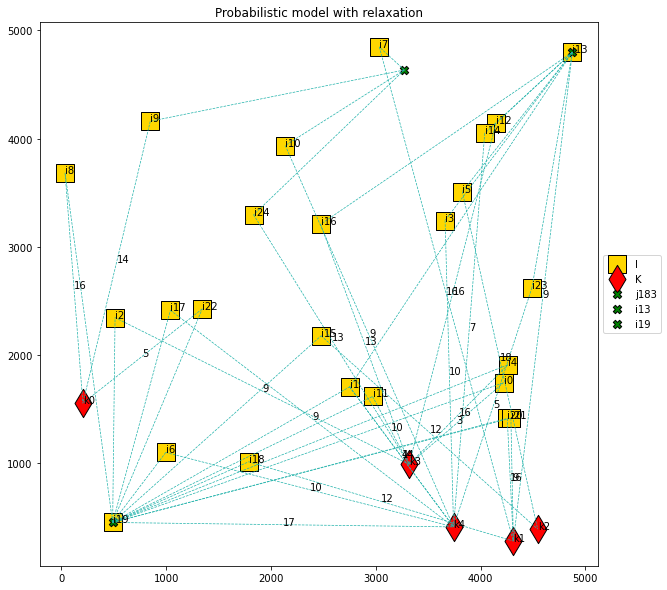

In [347]:
SolutionGraph(I, K, J, model_prob_rel)

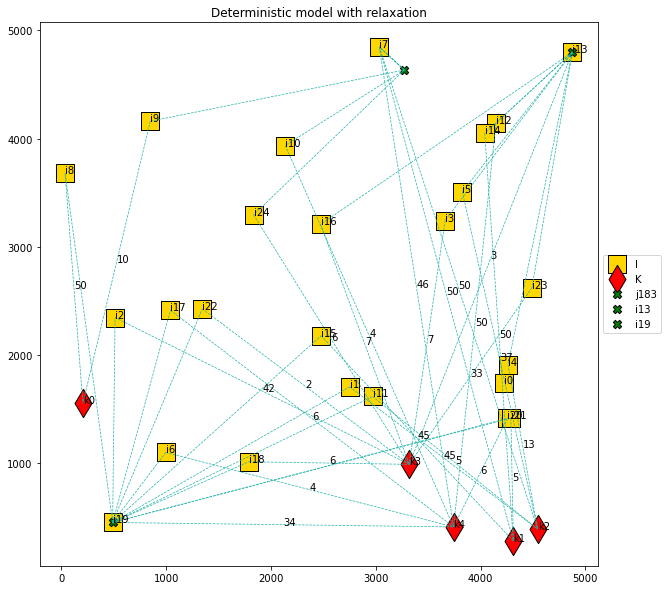

In [348]:
SolutionGraph(I, K, J, model_det_rel)

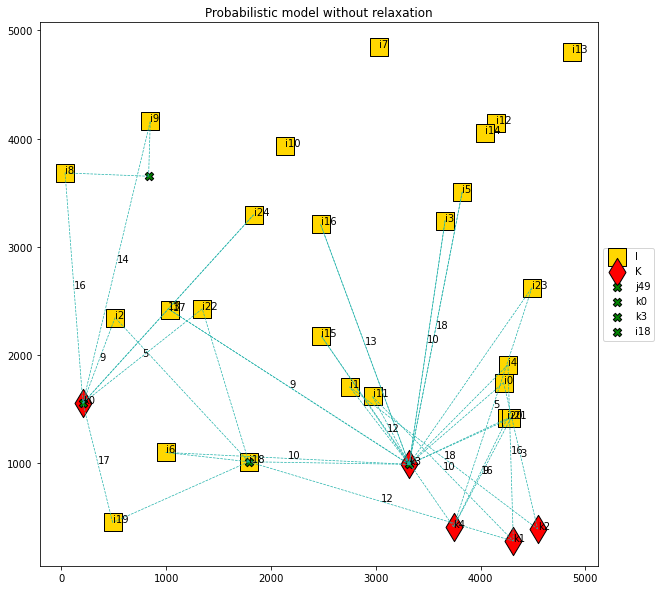

In [349]:
SolutionGraph(I, K, J, model_prob)

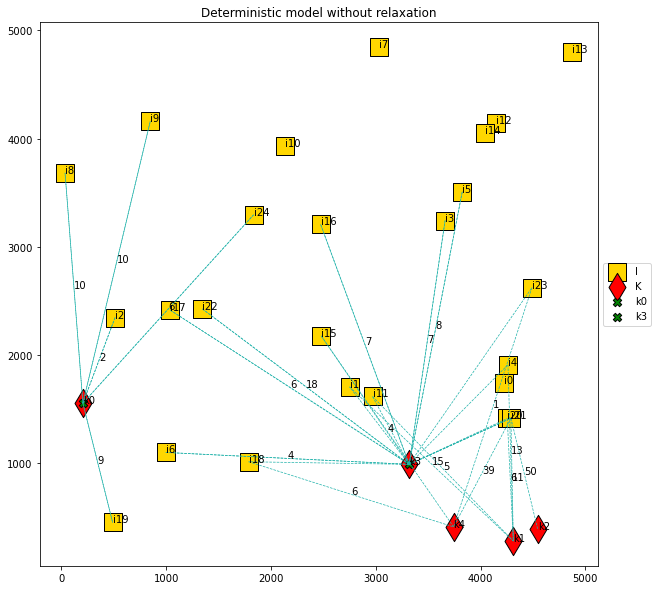

In [350]:
SolutionGraph(I, K, J, model_det)

1) complete information optimum - lower bound for optimum
2) price of uncertainty